# microPAM utilities
## micoPAM console
The microPAM software includes a basic menu that can interacted with from the PC, using either a terminal program or the following Python and R scripts. 

### Python script

In [32]:
import serial
import serial.tools.list_ports

from datetime import datetime
def PC_time():
    date_time=datetime.now()
    print("Date and time is:", date_time)

def microPAM_showParameters():
    s=serial.tools.list_ports.comports(True)
    print(s[0].device)
    with serial.Serial(s[0].device) as ser:
        ser.reset_input_buffer
        ser.write(b'?p\r')
        for ii in range(5):
            print(ser.readline().decode('utf-8').rstrip())
    print()

def microPAM_syncTime():
    s=serial.tools.list_ports.comports(True)

    date_time=datetime.now()
    dd=date_time.strftime('!d%Y-%m-%d\r')
    tt=date_time.strftime('!t%H:%M:%S\r')

    with serial.Serial(s[0].device) as ser:
        ser.write(dd.encode())
        str=ser.readline().decode('utf-8').rstrip()
        print(str)

    with serial.Serial(s[0].device) as ser:
        ser.write(tt.encode())
        print(ser.readline().decode('utf-8').rstrip())

def microPAM_setParameter(token,value):
    s=serial.tools.list_ports.comports(True)
    with serial.Serial(s[0].device) as ser:
        data="!"+token+str(value)+"\r"
        ser.write(data.encode())
        print(ser.readline().decode('utf-8').rstrip())

def microPAM_readLines(value):
    s=serial.tools.list_ports.comports(True)
    with serial.Serial(s[0].device) as ser:
        for ii in range(value):
            print(ser.readline().decode('utf-8').rstrip())

def microPAM_command(value):
    s=serial.tools.list_ports.comports(True)
    with serial.Serial(s[0].device) as ser:
        ser.write(value.encode())


### Example of python based setup of microPAM

In [33]:
PC_time()
microPAM_connected = 0      # change to 1 if microPAM is connected to USB
if microPAM_connected:
    microPAM_showParameters()
    microPAM_syncTime()
#    microPAM_setParameter("f",44100)
#    microPAM_setParameter("s",12)
#    microPAM_setParameter("c",1)
    microPAM_showParameters()

Date and time is: 2024-07-30 07:04:05.942779


### Example of python based monitoring of microPAM

In [34]:
if microPAM_connected:
    microPAM_command("m")   # switch on monitor
    microPAM_readLines(10)
    microPAM_command("m")   # switch off monitor

In [35]:
if microPAM_connected:
    microPAM_command("s")   # start archiving
    microPAM_readLines(5)
    microPAM_command("e")   # stop archiving

## microPAM GUI

In [1]:
#%%writefile microPAM_GUI.py 
# uncomment prev line to save cell to file
# micoPAM GUI
# use this cell to test and develop GUI
# to compile "pyinstaller microPAM_GUI.py --noconfirm"
# will generate "dist/micoPAM_GUI/microPAM_GUI.exe"
# and  "dist/micoPAM_GUI/_internal" with all required pyd/dll files
#
import tkinter as tk
import time
from datetime import datetime
import serial
import serial.tools.list_ports

class Window(tk.Frame):
    d_ref=15000

    def mEntry(self,txt,x,y,w,dx):
        label = tk.Label(text=txt,font=("Helvetica", 18))
        label.place(x=x-dx,y=y)
        edit = tk.Entry(text="", fg="Black", font=("Helvetica", 18),width=w)
        edit.place(x=x,y=y)
        return edit

    def mgetParam(self,ser,txt):
        ser.write(txt.encode())
        txt=ser.readline().decode('utf-8').rstrip()
        ip=txt.find("=")
        return txt[ip+2:]

    def mputEntry(self,edit,txt):
        edit.delete(0,tk.END)
        edit.insert(0,txt)

    def mUpdate(self,ser,edit,txt):
        ser.write(txt.encode())
        txt=ser.readline().decode('utf-8').rstrip()
        ip=txt.find("=")
        edit.delete(0,tk.END)
        edit.insert(0,txt[ip+2:])

    def msendEntry(self,ser,str,edit):
        data=str+edit.get()+"\r"
        ser.write(data.encode())

    def ndays(self,d,m,y):
        def lpY(y): return (y%4==0) | ((y%100==0) & (y%400>0))
        dom=[31,28,31,30,31,30,31,31,30,31,30]
        #
        # number of days since 1-1-1970
        y1=y-1970
        days=y1*365
        for ii in range(y1): 
            if lpY(1970+ii): days +=1 
        #
        m -= 1
        for ii in range(m):
            days += dom[ii]
            if ii==1:
                if lpY(y): days += 1
        #
        d -= 1
        days += d
        return days, (days+4)%7 # 1-1-70 was thursday 1-1-24 was monday
    
    def nidays(self,days):
        def lpY(y): return (y%4==0) | ((y%100==0) & (y%400>0))
        dom=[31,28,31,30,31,30,31,31,30,31,30]
        #
        y1=0
        while days>0:
            if lpY(1970+y1): 
                days -=366
            else:
                days -= 365
            y1 +=1
        #
        if y1>0:
            y1 -= 1
        if days<=0:
            if lpY(1970+y1): 
                days += 366
            else:
                days += 365
        #
        days += 1
        ii = 0
        while days >=0:
            if (ii==1) & lpY(1970+y1): days -=1
            days -= dom[ii]
            ii += 1
        ii=ii-1
        days += dom[ii]
        m = ii
        return (1970+y1,m+1,days)

    def __init__(self, master=None):
        tk.Frame.__init__(self, master)        
        self.master = master

        # widget can take all window
        self.pack(fill=tk.BOTH, expand=1)

        label1 = tk.Label(text="PC:",font=("Helvetica", 18))
        label1.place(x=100,y=10)
        self.pcClocklabel = tk.Label(text="", fg="Red", font=("Helvetica", 18))
        self.pcClocklabel.place(x=160,y=10)
        self.update_clock()

        label2 = tk.Label(text="MCU:",font=("Helvetica", 18))
        label2.place(x=80,y=60)
        self.mcuClocklabel = tk.Label(text="", fg="Black", font=("Helvetica", 18))
        self.mcuClocklabel.place(x=160,y=60)

        xo=120
        yo=110
        ii=0
        self.fsamp_edit = self.mEntry("fsamp:",xo,yo+ii*40,10,80); ii+=1
        self.proc_edit  = self.mEntry("proc:",xo,yo+ii*40,5,80); ii+=1
        self.shift_edit = self.mEntry("shift:",xo,yo+ii*40,5,80); ii+=1
        self.again_edit = self.mEntry("again:",xo,yo+ii*40,5,80); ii+=1

        xo=350
        yo=110
        ii=0
        self.t_acq_edit = self.mEntry("t_acq:",xo,yo+ii*40,5,80); ii+=1
        self.t_on_edit  = self.mEntry("t_on:",xo,yo+ii*40,5,80); ii+=1
        self.t_rep_edit = self.mEntry("t_rep:",xo,yo+ii*40,5,80); ii+=1
        ii=0
        xo += 160
        self.h_1_edit = self.mEntry("h_1:",xo,yo+ii*40,5,80); ii+=1
        self.h_2_edit = self.mEntry("h_2:",xo,yo+ii*40,5,80); ii+=1
        self.h_3_edit = self.mEntry("h_3:",xo,yo+ii*40,5,80); ii+=1
        self.h_4_edit = self.mEntry("h_4:",xo,yo+ii*40,5,80); ii+=1
        yo += 40
        self.d_start_edit = self.mEntry("d_start:",xo-320,yo+ii*40,3,90); 
        self.m_start_edit = self.mEntry("m_start:",xo-160,yo+ii*40,3,90); 
        self.y_start_edit = self.mEntry("y_start:",xo,yo+ii*40,5,90); ii+=1
        self.d_on_edit    = self.mEntry("d_on:",xo,yo+ii*40,5,80); ii+=1
        self.d_rep_edit   = self.mEntry("d_rep:",xo,yo+ii*40,5,80); ii+=1

        # create buttons
        xm=600
        exitButton = tk.Button(self, text="Exit ", command=self.clickExitButton, font=("Helvetica", 18))
        exitButton.place(x=xm, y=10)
        loadButton = tk.Button(self, text="Load", command=self.clickLoadButton, font=("Helvetica", 18))
        loadButton.place(x=xm, y=80)
        saveButton = tk.Button(self, text="Save", command=self.clickSaveButton, font=("Helvetica", 18))
        saveButton.place(x=xm, y=150)
        storeButton = tk.Button(self, text="Store", command=self.clickStoreButton, font=("Helvetica", 18))
        storeButton.place(x=xm, y=220)
        syncButton = tk.Button(self, text="Sync", command=self.clickSyncButton, font=("Helvetica", 18))
        syncButton.place(x=xm, y=310)
        self.storeButton=storeButton
        #
        date_time=datetime.now()
        self.mputEntry(self.d_start_edit,str(date_time.day))
        self.mputEntry(self.m_start_edit,str(date_time.month))
        self.mputEntry(self.y_start_edit,str(date_time.year))

        s=serial.tools.list_ports.comports(True)
        with serial.Serial(s[0].device) as ser:
            ser.reset_input_buffer()
            ser.reset_output_buffer()


    def clickExitButton(self):
        self.master.destroy() 

    def clickLoadButton(self):
        s=serial.tools.list_ports.comports(True)
        if len(s)==0:
            return
        with serial.Serial(s[0].device) as ser:
            ser.reset_input_buffer()
            # stop acquisition
            ser.write(b'e\r')
            txt=ser.readline().decode('utf-8').rstrip()
            # stop monitor
            ser.write(b':m0\r')
            txt=ser.readline().decode('utf-8').rstrip()
            ser.reset_input_buffer()
            #
            # load now data from device
            ser.write(b'?d\r')
            txt1=ser.readline().decode('utf-8').rstrip()
            ser.write(b'?t\r')
            txt2=ser.readline().decode('utf-8').rstrip()
            ip1=txt1.find("=")
            ip2=txt2.find("=")
            self.mcuClocklabel.configure(text=txt1[ip1+2:]+txt2[ip2+1:])
            #
            self.mUpdate(ser,self.t_acq_edit,"?a")
            self.mUpdate(ser,self.t_on_edit, "?o")
            self.mUpdate(ser,self.t_rep_edit,"?r")
            #
            self.mUpdate(ser,self.h_1_edit,"?1")
            self.mUpdate(ser,self.h_2_edit,"?2")
            self.mUpdate(ser,self.h_3_edit,"?3")
            self.mUpdate(ser,self.h_4_edit,"?4")
            #
            self.mUpdate(ser,self.d_on_edit,"?5")
            self.mUpdate(ser,self.d_rep_edit,"?6")
            #
            self.mUpdate(ser,self.fsamp_edit,"?f")
            self.mUpdate(ser,self.proc_edit, "?c")
            self.mUpdate(ser,self.shift_edit,"?s")
            self.mUpdate(ser,self.again_edit,"?g")

            days=int(self.mgetParam(ser,"?0"))
            print('get',days)
            year,month,day=self.nidays(days+self.d_ref)
            self.mputEntry(self.d_start_edit,str(day))
            self.mputEntry(self.m_start_edit,str(month))
            self.mputEntry(self.y_start_edit,str(year))
        self.storeButton["state"]=tk.DISABLED

    def clickSaveButton(self):
        dx=self.d_start_edit.get()
        mx=self.m_start_edit.get()
        yx=self.y_start_edit.get()
        days,dow=self.ndays(int(dx),int(mx),int(yx))
        #
        s=serial.tools.list_ports.comports(True)
        with serial.Serial(s[0].device) as ser:
            ser.read_all()
            self.msendEntry(ser,'!a',self.t_acq_edit)
            self.msendEntry(ser,'!o',self.t_on_edit)
            self.msendEntry(ser,'!r',self.t_rep_edit)
            self.msendEntry(ser,'!1',self.h_1_edit)
            self.msendEntry(ser,'!2',self.h_2_edit)
            self.msendEntry(ser,'!3',self.h_3_edit)
            self.msendEntry(ser,'!4',self.h_4_edit)
            self.msendEntry(ser,'!5',self.d_on_edit)
            self.msendEntry(ser,'!6',self.d_rep_edit)
            #
            self.msendEntry(ser,'!f',self.fsamp_edit)
            self.msendEntry(ser,'!c',self.proc_edit)
            self.msendEntry(ser,'!s',self.shift_edit)
            self.msendEntry(ser,'!g',self.again_edit)
            #
            data="!0"+str(days-self.d_ref)+"\r"
            print('put', data)
            ser.write(data.encode())
            ser.read_all()
        self.storeButton["state"]=tk.NORMAL

    def clickStoreButton(self):
        s=serial.tools.list_ports.comports(True)
        with serial.Serial(s[0].device) as ser:
            ser.read_all()
            ser.write("!w1\r".encode())
            time.sleep(0.1)
            txt=ser.readline().decode('utf-8').rstrip()
            #
            ser.write(":w".encode())
            time.sleep(0.1)
            txt=ser.readline().decode('utf-8').rstrip()
            txt=ser.readline().decode('utf-8').rstrip()
            print(txt)

    def clickSyncButton(self):
        s=serial.tools.list_ports.comports(True)
        date_time=datetime.now()
        dd=date_time.strftime("!d%Y-%m-%d\r")
        tt=date_time.strftime("!t%H:%M:%S\r")

        with serial.Serial(s[0].device) as ser:
            ser.write(tt.encode())
        with serial.Serial(s[0].device) as ser:
            ser.write(dd.encode())
        with serial.Serial(s[0].device) as ser:
            ser.write(b':c')

    def update_clock(self):
        now = time.strftime("%Y-%m-%d %H:%M:%S")
        self.pcClocklabel.configure(text=now)
        self.after(1000, self.update_clock)

root = tk.Tk()
app = Window(root)
root.wm_title("MicroPAM V3 (WMXZ)")
root.geometry("700x500")

microPAM_connected = 1      # change to 1 if microPAM is connected to USB
if microPAM_connected:
    root.after(1000, app.update_clock)
    root.mainloop() 

Overwriting microPAM_GUI.py


## R scripts
The following functions allow the interaction with the microPAM using R 

```
library('serial')

listParameters <- function()
{
	ser <- listPorts()
	com <- serialConnection(name="microPAM",port=ser,
			buffering='line',
			translation='cr')
	if(isOpen(com)==FALSE) open(com)

	write.serialConnection(com,"?p\r\n")
	flush(com)
	Sys.sleep(0.1)
	ret<-read.serialConnection(com)
	close(com)
	cat(c(ret,"\n"))
}

syncTime <- function()
{
	ser <- listPorts()
	com <- serialConnection(name="microPAM",port=ser,
			buffering='line',
			translation='cr')
	if(isOpen(com)==FALSE) open(com)

	now=Sys.time()

	dd=format(now,"!d%Y-%m-%d\r\n")
	write.serialConnection(com,dd)
	flush(com)
	Sys.sleep(0.1)

	ret<-read.serialConnection(com)
	cat(ret)

	tt=format(now,"!t%H-%M-%S\r\n")
	write.serialConnection(com,tt)
	flush(com)
	Sys.sleep(0.1)

	ret<-read.serialConnection(com)

	cat(c(ret,"\n"))
	close(com)
}

setParameter <- function(token,value)
{
	ser <- listPorts()
	com <- serialConnection(name="microPAM",port=ser,
			buffering='line',
			translation='cr')
	if(isOpen(com)==FALSE) open(com)

	uu=sprintf("!%s%d\r\n",token,value)
	write.serialConnection(com,uu)
	flush(com)
	Sys.sleep(0.1)

	ret<-read.serialConnection(com)
	cat(c(ret,"\n"))
	close(com)
}

doCommand <- function(token)
{
	ser <- listPorts()
	com <- serialConnection(name="microPAM",port=ser,
			buffering='line',
			translation='cr')
	if(isOpen(com)==FALSE) open(com)

	uu=sprintf("%s\r\n",token)
	write.serialConnection(com,uu)
	flush(com)
	close(com)
}

monitor <- function(num)
{
	ser <- listPorts()
	com <- serialConnection(name="microPAM",port=ser,
			buffering='line',
			translation='lf')
	if(isOpen(com)==FALSE) open(com)

	ret<-read.serialConnection(com)
	for (ii in 1:num)
	{ Sys.sleep(1)
  	  ret<-read.serialConnection(com)
	  cat(c(ret,'\n'))
	}
	close(com)
}
```

## basic audio test (wav file generation) script

In [37]:
import numpy as np
import wavio
rate = 22050             # samples per second
T = 3                    # sample duration (seconds)
f = 440.0                # sound frequency (Hz)
t = np.linspace(0, T, T*rate, endpoint=False)
sig = np.sin(2 * np.pi * f * t)
wavio.write("sine24.wav", sig, rate, sampwidth=3)   # 24 bit data (sampwidth=3)

## Elliptical filters
Low-pass filter with elliptical (Cauer) filter for very low (< 1kHz) corner frequencies
- first decimate data to about 2400 Hz
- estimate biquad filter coefficients with python script
- apply 3 biquad filter

[[ 0.00454991  0.00480905  0.00454991  1.         -1.54273107  0.64191613]
 [ 1.         -0.63758644  1.          1.         -1.43156463  0.80165859]
 [ 1.         -1.02047284  1.          1.         -1.37624928  0.94360981]]


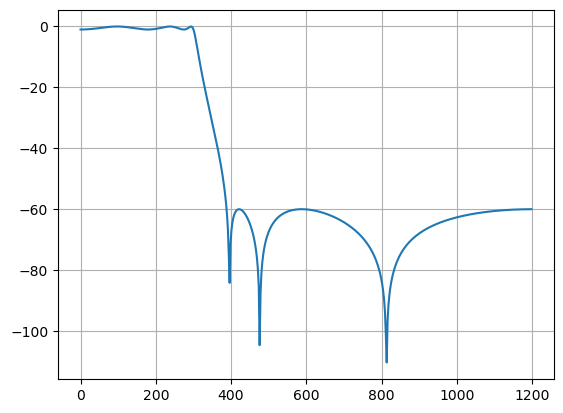

In [38]:
import numpy as np
from scipy.signal import ellip, sosfreqz
import scipy.signal as sig
import matplotlib.pyplot as plt

Fs = 2400

x = sig.ellip(6, 1, 60, [300 / (Fs / 2)], output='sos')
print(x)
freqs, resps = sig.sosfreqz(x, fs = Fs)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()

ax.plot(freqs, 20 * np.log10(np.abs(resps)))

plt.show()


## Testing the date functions

In [2]:

import numpy as np



#tt=1722252600 # 29-07-2024 11:30:00
#tt=1722211200 # 29-07-2024 00:00:00
#tt=1704067200 # 01-01-2024
#tt=946684800  # 01-01-2000


def ndays(d,m,y):
    def lpY(y): return (y%4==0) | ((y%100==0) & (y%400>0))
    dom=[31,28,31,30,31,30,31,31,30,31,30]
    #
    # number of days since 1-1-1970
    y1=y-1970
    days=y1*365
    for ii in range(y1): 
        if lpY(1970+ii): days +=1 
    #
    m -= 1
    for ii in range(m):
        days += dom[ii]
        if ii==1:
            if lpY(y): days += 1
    #
    d -= 1
    days += d
    return days, (days+4)%7 # 1-1-70 was thursday: dow=4 (sunday=0)
 
def nidays(days):
    def lpY(y): return (y%4==0) | ((y%100==0) & (y%400>0))
    dom=[31,28,31,30,31,30,31,31,30,31,30]
    #
    y1=0
    while days>0:
        if lpY(1970+y1): 
            days -=366
        else:
            days -= 365
        y1 +=1
    #
    if y1>0:
        y1 -= 1
    if days<0:
        if lpY(1970+y1): 
            days += 366
        else:
            days += 365
    #
    days += 1
    ii = 0
    while days >=0:
        if (ii==1) & lpY(1970+y1): days -=1
        days -= dom[ii]
        ii += 1
    ii=ii-1
    days += dom[ii]
    m = ii
    return (1970+y1,m+1,days)

#days,dow=ndays(1,1,1970)
days,dow=ndays(4,10,2024)
print(dow,days,days*(24*3600))

y1,m1,d1=nidays(days)
print(y1,m1,d1)

y1,m1,d1=nidays(20000)
print(y1,m1,d1)



5 20000 1728000000
2024 10 4
2024 10 4
